In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
DB_FILENAME = 'available_log.db'

In [60]:
time = np.arange(24)
time

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [61]:
probs_mo = np.array(25*[np.nan])
probs_mo[0] = 1
probs_mo[6] = 1
probs_mo[12] = 0.1
probs_mo[18] = 0.8
probs_mo[24] = probs_mo[0]
not_nan_inds_mo = np.where(~np.isnan(probs_mo))[0]

probs_sh = np.array(25*[np.nan])
probs_sh[0] = 0.7
probs_sh[6] = 0.7
probs_sh[12] = 0.9
probs_sh[18] = 0.5
probs_sh[24] = probs_sh[0]
not_nan_inds_sh = np.where(~np.isnan(probs_sh))[0]

probs_no = np.array(25*[np.nan])
probs_no[0] = 1
probs_no[6] = 1
probs_no[12] = 0.1
probs_no[18] = 0.1
probs_no[24] = probs_no[0]
not_nan_inds_no = np.where(~np.isnan(probs_no))[0]

probs_je = np.array(25*[np.nan])
probs_je[0] = 1
probs_je[6] = 1
probs_je[12] = 1
probs_je[18] = 1
probs_je[24] = probs_je[0]
not_nan_inds_je = np.where(~np.isnan(probs_je))[0]

x_mo = not_nan_inds_mo
y_mo = probs_mo[not_nan_inds_mo]

x_sh = not_nan_inds_sh
y_sh = probs_sh[not_nan_inds_sh]

x_no = not_nan_inds_no
y_no = probs_no[not_nan_inds_no]

x_je = not_nan_inds_je
y_je = probs_je[not_nan_inds_je]

xs = [x_mo, x_sh, x_no, x_je]
ys = [y_mo, y_sh, y_no, y_je]
titles = ['mosachim', 'shapira', 'north', 'jerusalem']

def prob_for_finding(time,x,y):
    return np.interp(time, x, y)

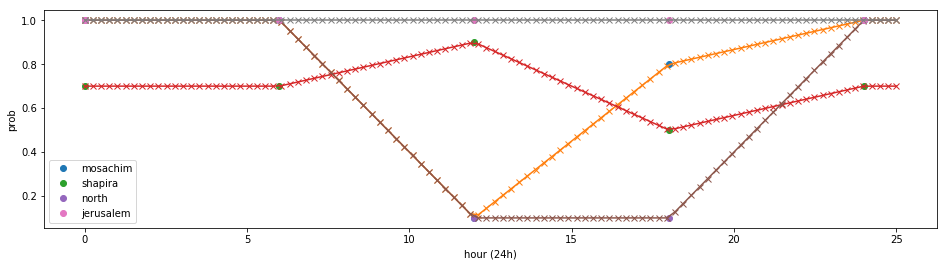

In [62]:

xvals = np.linspace(0, 25, 100)
plt.figure(figsize=(16,4))
for i in range(len(xs)):
    yinterp = np.interp(xvals, xs[i], ys[i])

#     plt.figure(figsize=(16,4))
    plt.plot(xs[i], ys[i], 'o', label=titles[i])
    plt.xlabel('hour (24h)')
    plt.ylabel('prob')
#     plt.title(titles[i])
    plt.grid()

    plt.plot(xvals, yinterp, '-x')
plt.legend()
plt.show()

In [63]:
update_times = np.random.uniform(low=0,high=24,size=1000)

In [64]:
results = []
for i in range(4):
    results.append(prob_for_finding(update_times, xs[i], ys[i]) > np.random.uniform(size=update_times.shape))

### create the log table

In [65]:
with sqlite3.connect(DB_FILENAME) as con:
    cur = con.cursor()
    cur.execute(""" CREATE TABLE IF NOT EXISTS log_tbl (
                    id INTEGER PRIMARY KEY,
                    area_id INT,
                    time REAL,
                    found REAL
                    );""")
    cur.close()

### insert data to the log table

In [66]:
for i in range(4):
    n = len(update_times)
    with sqlite3.connect(DB_FILENAME) as con:
        cur = con.cursor()
        data = list(zip(n*[i+1], list(update_times), list(1.0*results[i])))
        stmt = "INSERT INTO log_tbl (area_id, time, found) VALUES (?, ?, ?)"
        cur.executemany(stmt, data)
        cur.close()

### calculate probability given time for all polygons

In [80]:
10/60

0.16666666666666666

In [85]:
def calculat_probs(user_time, delta=10/60):
    delta = (10/60)
    with sqlite3.connect(DB_FILENAME) as con:
            cur = con.cursor()
            stmt = """  SELECT AVG(found)
                        FROM log_tbl 
                        WHERE (? - ? < time) AND (time < ? + ?)
                        GROUP BY area_id
                        """
            cur.execute(stmt, (user_time,delta,user_time,delta))
            res = [p[0] for p in cur.fetchall()]
            cur.close()
    return res

In [91]:
calculat_probs(13, delta=10/60)

[0.125, 0.875, 0.0, 1.0]

In [77]:
user_time = 7.4
delta = (10/60)
with sqlite3.connect(DB_FILENAME) as con:
        cur = con.cursor()
        stmt = """  SELECT AVG(found)
                    FROM log_tbl 
                    WHERE (? - ? < time) AND (time < ? + ?)
                    GROUP BY area_id
                    """
        cur.execute(stmt, (user_time,delta,user_time,delta))
        res = [p[0] for p in cur.fetchall()]
        cur.close()
res

[0.7857142857142857, 0.8571428571428571, 0.9285714285714286, 1.0]